# Representation of text data

Using the notebook from the previous homework we extracted around 2000 reviews from 20 movies. We will use this dataset to experiment with different methods of representation of text data.

In [3]:
import pandas as pd

df = pd.read_csv("../homework 1/imdb_reviews.csv", index_col=0)
df.head()

,movie,title,text,score,user,date,helpfulness_votes,positive_helpfulness_votes
0,Couples Retreat,Worst movie I've seen in a while...,I watched this for free On Demand and still fe...,5.0,glyeakley,2010/09/25,47,30
1,Disaster Movie,The irony is very correct.,"Since the name of the movie is ""Disaster Movie...",NaN,mewte,2008/08/29,411,345
2,Seven Psychopaths,"Skinny, toothless, and blind","Hmm, it's quite risky with all these movies th...",6.0,mircea-lungu,2013/04/21,24,11
3,The Counselor,"A dark, bleak masterpiece about predators - 10/10",Don't believe the bad reviews here: If you lov...,10.0,rockenrohl,2013/10/26,139,86
4,Scouts Guide to the Zombie Apocalypse,Scouts vs. Zombies gotta like that!,Comedy and Horror mix well in this coming of a...,6.0,philipmorrison-73118,2016/01/24,3,2


We will keep only the text and score fields since we are aiming at a classification task for positive, negative and neutral reviews. We also remove any reviews without a score.

In [4]:
df = df.drop(["movie", "title", "user", "date", "helpfulness_votes", "positive_helpfulness_votes"], axis=1)
df = df.dropna()
print(len(df))
df.head()

44653


,text,score
0,I watched this for free On Demand and still fe...,5.0
2,"Hmm, it's quite risky with all these movies th...",6.0
3,Don't believe the bad reviews here: If you lov...,10.0
4,Comedy and Horror mix well in this coming of a...,6.0
5,"The movie failed to inspire, motivate, or even...",2.0


We plot the frequencies for each possible score in the dataset.

<AxesSubplot:>

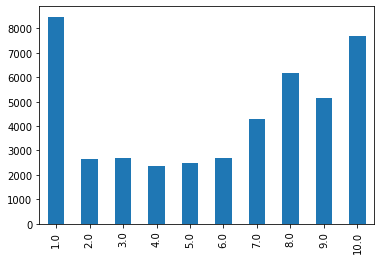

In [5]:
df["score"].value_counts().sort_index().plot(kind="bar")

As we can see the dataset is imbalanced, as we have more positive reviews. That is to be expected since we collected those reviews from somewhat popular movies.

For our classification purposes we will consider any score less than or equal to 3 to be negative, anything at least 8, positive, and the rest neutral.

In [64]:
def class_from_score(score):
    if score <= 3:
        return -1
    elif score >= 8:
        return 1
    else:
        return 0

df["class"] = [class_from_score(score) for score in df["score"]]
df.head()

,text,score,class
0,There is little that I can do by way of review...,10.0,1
1,I recorded this on my Sky Plus box out of curi...,10.0,1
2,Hard to believe that so many people seem to be...,1.0,-1
3,"Wow, was not expecting that! Popped into the c...",10.0,1
4,Saw this at a local film festival with little ...,10.0,1


<AxesSubplot:>

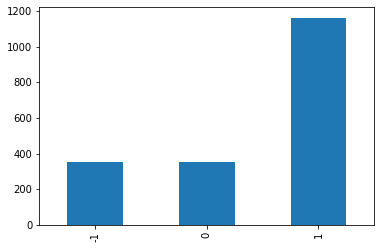

In [65]:
df["class"].value_counts().sort_index().plot(kind="bar")

We split our dataset into train (80%), dev (10%) and test (10%) sets.

In [66]:
from sklearn.model_selection import train_test_split

df = df.drop(["score"], axis=1)
df_train, df_rest = train_test_split(df, test_size=0.2)
df_dev, df_test = train_test_split(df_rest, test_size=0.5)

df_train.reset_index(inplace=True, drop=True)
df_dev.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

print(len(df_train), len(df_dev), len(df_test))
df_train.head()

1492 187 187


,text,class
0,I see a lot of positive reviews for this movie...,0
1,Crash is a film about racism and race relation...,-1
2,I saw this originally in a theater and then ag...,1
3,Why does this film have such a high rating? I'...,-1
4,This is an advocacy documentary film about the...,1


## CountVectorizer
The first example uses the CountVectorizer class from scikit-learn. With this we can build a bag-of-words representation of our text data.

First thing we need to take care of is the preprocessing and tokenization of our data. Recall that some cleaning of the data was done in the previous notebook. Here we will remove the URLs from the text (all URLs were previously replaced with a special token). We will then remove all symbols except latin letters, digits and basic punctuation. All spaces will then be contracted and stripped. We finish the preprocessing step with lower-casing our text.

For tokenization, we use SpaCy, after which each token is run through a stemmer, returning, in the end, the list of our tokens.

In [67]:
import nltk
import re
import spacy

stemmer = nltk.stem.PorterStemmer()
spacy_nlp = spacy.load("en_core_web_md")

def remove_url(text):
    return text.replace("[URL]", "")

def remove_symbols(text):
    return re.sub(r"[^a-zA-Z0-9.,?!'-]", " ", text)

def contract_spaces(text):
    return re.sub("\s+", " ", text).strip()

def lowercase(text):
    return text.lower()

def preprocessor(dirty_text):
    text = remove_url(dirty_text)
    text = remove_symbols(text)
    text = contract_spaces(text)
    text = lowercase(text)

def tokenize(text, spacy_nlp):
    return [token.text for token in spacy_nlp(text)]

def stem(tokens, stemmer):
    return [stemmer.stem(token) for token in tokens]

def tokenizer(text, spacy_nlp=spacy_nlp, stemmer=stemmer):
    tokens = tokenize(text, spacy_nlp)
    stemmed_tokens = stem(tokens, stemmer)
    return stemmed_tokens


In [70]:
print(df_train["text"][10])
print(preprocess(df_train["text"][10]))
print(tokenize(preprocess(df_train["text"][10])))

Not a single likable character in the movie. The main protagonist inspector was cringe to say the least. After sitting for 2 and half hour you get half of a story. So many unanswered questions. Pointless movie. One good thing i have to say about the movie is locations and cinematography.
not a single likable character in the movie. the main protagonist inspector was cringe to say the least. after sitting for 2 and half hour you get half of a story. so many unanswered questions. pointless movie. one good thing i have to say about the movie is locations and cinematography.
['not', 'a', 'singl', 'likabl', 'charact', 'in', 'the', 'movi', '.', 'the', 'main', 'protagonist', 'inspector', 'wa', 'cring', 'to', 'say', 'the', 'least', '.', 'after', 'sit', 'for', '2', 'and', 'half', 'hour', 'you', 'get', 'half', 'of', 'a', 'stori', '.', 'so', 'mani', 'unansw', 'question', '.', 'pointless', 'movi', '.', 'one', 'good', 'thing', 'i', 'have', 'to', 'say', 'about', 'the', 'movi', 'is', 'locat', 'and', 

CountVectorizer needs to be fit on a set of texts in order to build the vocabulary. For that we will use the training set.  After that, the CV can be used to get the bag-of-words representation of any text. As we can see, running it on the train dataset, we get a 2d array with the number of rows equal to the number of texts, and the columns corresponding to the words in the vocabulary.

In [71]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(preprocessor=preprocessor, tokenizer=tokenizer, max_features=10000)
cv.fit(df_train["text"])
bow_train = cv.transform(df_train["text"])

print(bow_train.shape)

(1492, 10000)


Let's look at the features extracted for a text sample. As we can see, not all tokens are counted, since some of them are not part of the vocabulary (recall that we limited the size of the vocabulary to 10000).

In [86]:
import numpy as np

print(len(tokenize(preprocess(df_train["text"][77]))))
print(np.sum(bow_train[77]))

words = []
for word, idx in cv.vocabulary_.items():
    if bow_train[77, idx] > 0:
        words.append(word)

print(df_train["text"][77])
print(words)

166
164
Since I saw "Fight Club", I have never witnessed such a performance by this great actor named Edward Norton. The great performance of the "double sided blade roll" of Aron/Roy is done with extraordinary finesse since he is known for his dual-sided acting skills when playing calm/aggressive or good/bad figures. Putting aside the fact that I heard and read about the big sacrifices that Norton did for the filming of "Fight Club" (losing 20 kilos and gaining the fit and full of muscles body in just 40 days) I wouldn't bee so amazed of the Aaron/Roy performance in "Primal Fear". Edward Norton leaves us stunned again. He plays the role of a 19 years old altar-boy in a catholic church with such a grace, that even a bad-ass serial killer would be jealous. Seen the movie, loved the performance and did another bow to Edward Norton!
['i', 'a', 'of', 'for', 'thi', 'movi', 'have', 'so', '.', 'is', 'the', 'to', 'and', 'about', 'be', 'or', 'seen', 'with', 'just', 'anoth', '!', 'when', 'that',

In the example above the features are just raw counts of the vocabulary tokens. Most of the time we would like those features to be normalized. We can employ the TfidfTransformer to choose which kind of normalization to use, and also we have the option to rescale the weights using Term frequency–Inverse document frequency (by setting the use_idf flag).

In [87]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipeline = Pipeline([
    ('count', CountVectorizer(preprocessor=preprocess, tokenizer=tokenize, max_features=10000)),
    ('tfid', TfidfTransformer(norm="l2", use_idf=True))
])

train_features = pipeline.fit_transform(df_train["text"])
print(train_features.shape)

(1492, 10000)


In [88]:
np.linalg.norm(train_features[10].toarray())

1.0

We can use the transform method on other sets of texts as well.

In [89]:
dev_features = pipeline.transform(df_dev["text"])
print(dev_features.shape)
print(np.linalg.norm(dev_features[10].toarray()))

(187, 10000)
1.0


We can also specify using n-grams instead of singular tokens. Here is an example of counting bigrams.

In [90]:
pipeline = Pipeline([
    ('count', CountVectorizer(preprocessor=preprocess, tokenizer=tokenize, max_features=10000, ngram_range=(2, 2))),
    ('tfid', TfidfTransformer(norm="l2", use_idf=True))
])

train_features = pipeline.fit_transform(df_train["text"])
print(train_features.shape)

(1492, 10000)


Let's print some of the bigrams from the vocabulary.

In [91]:
from random import sample

print(sample(list(pipeline["count"].vocabulary_.keys()), 20))

['confus and', 'new york', 'for so', 'will leav', 'an end', 'touch me', 'eye of', 'have fun', 'alway be', 'think .', 'children ,', 'you do', 'a planet', 'suffer .', 'good peopl', 'fight scene', 'societi that', 'dialogu ,', 'stori tell', 'bueller ,']


## Word Embeddings

The second example concerns word embeddings. For this we will use the pyTorch library, alongside its NLP extension torchtext. First of all we need to build the torchtext datasets from the dataframes computed above. This conversion is not supported by default so this is a class that does just that.

In [92]:
from torchtext import data

class DataFrameDataset(data.Dataset):

    def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
        fields = [('text', text_field), ('label', label_field)]
        examples = []
        for i, row in df.iterrows():
            label = row["class"] if not is_test else None
            text = row["text"]
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, text_field, label_field, train_df, dev_df=None, test_df=None, **kwargs):
        train_data, dev_data, test_data = (None, None, None)

        if train_df is not None:
            train_data = cls(train_df.copy(), text_field, label_field, **kwargs)
        if dev_df is not None:
            dev_data = cls(dev_df.copy(), text_field, label_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), text_field, label_field, True, **kwargs)

        return tuple(d for d in (train_data, dev_data, test_data) if d is not None)

Let's now define our data fields (one for text, the other for the class label). The text one is going to be a sequential one since it will store for each dataset example the list of tokens. We will provide it with a simple tokenization method that just removes the URLs and runs the SpaCy tokenizer.

After we define our fields and build our datasets, we build the vocabulary based on our tokens. This will do the following:
 * keep the most frequent tokens from our training dataset
 * build a lookup table for tokens based on an integer index
 * for each word in the vocabulary store its embedding vector (in this case we used 300-dimensional GloVe vectors)
 * if no pretrained embedding is available for a word, generate a random one

In [93]:
import torch

def tokenize(text, spacy_nlp=spacy_nlp):
    urls_removed = text.replace("[URL]", "")
    tokens = [token.text for token in spacy_nlp(text)]
    return tokens

TEXT_FIELD = data.Field(
    sequential=True,
    tokenize=tokenize,
    lower=True,
    batch_first=True,
)

LABEL_FIELD = data.Field(
    sequential=False,
    use_vocab=False
)

train_ds, dev_ds, test_ds = DataFrameDataset.splits(
  text_field=TEXT_FIELD, label_field=LABEL_FIELD, train_df=df_train, dev_df=df_dev, test_df=df_test
)

TEXT_FIELD.build_vocab(
    train_ds,
    max_size=10000,
    vectors="glove.6B.300d",
    unk_init=torch.Tensor.normal_
)

Let's look at our most frequent words from the vocabulary.

In [94]:
from collections import Counter
cnt = Counter(TEXT_FIELD.vocab.freqs)
print(cnt.most_common(20))

[('the', 22363), ('.', 18792), (',', 18478), ('and', 11683), ('a', 10740), ('of', 10076), ('to', 9620), ('is', 7922), ('it', 6592), ('in', 6403), ('i', 5886), ('that', 5474), ('this', 4919), ("'s", 4078), ('"', 3534), ('movie', 3387), ('-', 3207), ('as', 3156), ('was', 3058), ('with', 3030)]


Below is an illustration of switching between words, indexes and their embeddings.

In [95]:
print(TEXT_FIELD.vocab.vectors.shape)
print(TEXT_FIELD.vocab.itos[10])
print(TEXT_FIELD.vocab.stoi["it"])
print(TEXT_FIELD.vocab.vectors[10, :20])

torch.Size([10002, 300])
it
10
tensor([ 0.0333, -0.0408, -0.0484,  0.1202, -0.1391, -0.1769, -0.0629,  0.1706,
         0.2008, -2.4287,  0.4070, -0.0993,  0.0723,  0.2151,  0.2494,  0.2585,
        -0.6637,  0.2247,  0.2576, -0.1746])


We see that there are 10002 vector embeddings of size 300. This is because we have a 10000 words vocabulary and 2 special tokens (the padding token and the UNK token for the unknown word).

Let's split our data into batches in order to be able to iterate through it.

In [96]:
BATCH_SIZE = 64
train_it, dev_it, test_it = data.BucketIterator.splits((train_ds, dev_ds, test_ds), batch_size=BATCH_SIZE)

Below we look at the shape of the first batch. As expected we see 64 examples. For each example we have an array of fixed size. That array contains the integer indexes of the words from the example, in the order that they appear in. In order for all of these arrays to be of the same size, the padding token is appended to the shorter texts to match the longest one in the batch.

In [97]:
for batch in train_it:
    print(batch.text.shape)
    print(batch.text[10])
    break

torch.Size([64, 1263])
tensor([10, 15,  6,  ...,  1,  1,  1])


Now for the embeddings. We use the Embedding layer from pyTorch. This is just a lookup table that maps words' integer ids to their embedding. We initialize these embeddings with the ones stored in our text field, then make sure that the vectors for the UNK and PAD tokens are zero.

In [98]:
import torch.nn as nn

EMBEDDING_DIM = 300

emb = nn.Embedding(len(TEXT_FIELD.vocab), EMBEDDING_DIM)
pretrained_embeddings = TEXT_FIELD.vocab.vectors
emb.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT_FIELD.vocab.stoi[TEXT_FIELD.unk_token]
PAD_IDX = TEXT_FIELD.vocab.stoi[TEXT_FIELD.pad_token]

emb.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
emb.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


By running the embedding layer on a batch, we are able to see that we get a 3d array where the first dimension is the number of examples in the batch, the second one corresponds to the number of words in an example, and for each of these words we get the embedding of size 300. Below we check that indeed the embedding returned for the first word in the first example is the same as the embedding computed in the text field.

In [99]:
for batch in train_it:
    with torch.no_grad():
        embeddings = emb(batch.text)
        print(embeddings.shape)
        print(embeddings[0, 0, :20])
        print(batch.text[0, 0])
        print(TEXT_FIELD.vocab.vectors[batch.text[0, 0]][:20])
        print(TEXT_FIELD.vocab.itos[batch.text[0, 0]])
    break


torch.Size([64, 1169, 300])
tensor([ 6.2652e-01,  1.9696e-01, -4.2650e-01,  8.8362e-01,  4.4016e-01,
        -1.1991e-01, -1.1986e-01, -3.6827e-02,  4.9810e-04, -2.0244e-01,
         2.9505e-01, -2.9846e-02, -9.2499e-01,  1.1632e-01, -1.8483e-01,
        -3.5368e-01,  2.7334e-01, -1.2624e-01,  1.8222e-01, -1.9355e-02])
tensor(1390)
tensor([ 6.2652e-01,  1.9696e-01, -4.2650e-01,  8.8362e-01,  4.4016e-01,
        -1.1991e-01, -1.1986e-01, -3.6827e-02,  4.9810e-04, -2.0244e-01,
         2.9505e-01, -2.9846e-02, -9.2499e-01,  1.1632e-01, -1.8483e-01,
        -3.5368e-01,  2.7334e-01, -1.2624e-01,  1.8222e-01, -1.9355e-02])
wasted
